# Telco Customer Dataset: SQL-First Analysis in Jupyter

## 1) Introduction
This notebook demonstrates a professional, SQL-first workflow for analyzing a telco customer dataset. The objectives are to:
- Load the CSV into a relational database (SQLite) for repeatable SQL analysis.
- Understand the data structure (types, missingness, uniqueness, basic stats).
- Clean and standardize fields in a reusable way.
- Perform exploratory and advanced analyses focused on churn, revenue, and customer behavior.
- Provide visualization guidance to communicate insights.

**Dataset overview:** A customer-level table (one row per customer) with demographics, location, service subscriptions, billing/charges, satisfaction, and churn-related fields (label/score/category/reason).


In [5]:
import pandas as pd
import sqlite3

TABLE_RAW = "telco_raw"
TABLE_CLEAN = "telco_clean"

# Use in-memory DB for notebook workflow (switch to "telco.db" for persistence)
conn = sqlite3.connect("telco.db")

df = pd.read_csv('telco.csv')

# Load into SQLite
df.to_sql(TABLE_RAW, conn, index=False, if_exists="replace")

def q(sql: str, params=None):
    """Run a SQL query and return a pandas DataFrame."""
    return pd.read_sql_query(sql, conn, params=params)

# Preview
q(f"SELECT * FROM {TABLE_RAW} LIMIT 5;")


,Customer ID,Gender,Age,Under 30,Senior Citizen,Married,Dependents,Number of Dependents,Country,State,...,Total Extra Data Charges,Total Long Distance Charges,Total Revenue,Satisfaction Score,Customer Status,Churn Label,Churn Score,CLTV,Churn Category,Churn Reason
0,8779-QRDMV,Male,78,No,Yes,No,No,0,United States,California,...,20,0.00,59.65,3,Churned,Yes,91,5433,Competitor,Competitor offered more data
1,7495-OOKFY,Female,74,No,Yes,Yes,Yes,1,United States,California,...,0,390.80,1024.10,3,Churned,Yes,69,5302,Competitor,Competitor made better offer
2,1658-BYGOY,Male,71,No,Yes,No,Yes,3,United States,California,...,0,203.94,1910.88,2,Churned,Yes,81,3179,Competitor,Competitor made better offer
3,4598-XLKNJ,Female,78,No,Yes,Yes,Yes,1,United States,California,...,0,494.00,2995.07,2,Churned,Yes,88,5337,Dissatisfaction,Limited range of services
4,4846-WHAFZ,Female,80,No,Yes,Yes,Yes,1,United States,California,...,0,234.21,3102.36,2,Churned,Yes,67,2793,Price,Extra data charges


In [6]:
q(f"PRAGMA table_info({TABLE_RAW});")


,cid,name,type,notnull,dflt_value,pk
0,0,Customer ID,TEXT,0,None,0
1,1,Gender,TEXT,0,None,0
2,2,Age,INTEGER,0,None,0
3,3,Under 30,TEXT,0,None,0
4,4,Senior Citizen,TEXT,0,None,0
5,5,Married,TEXT,0,None,0
6,6,Dependents,TEXT,0,None,0
7,7,Number of Dependents,INTEGER,0,None,0
8,8,Country,TEXT,0,None,0
9,9,State,TEXT,0,None,0


## 3) Data Understanding
We profile each column for:
- **Data type** (as inferred by pandas)
- **Missing values** (NULLs / blanks)
- **Cardinality** (unique values)
- **Basic statistics** for numeric fields (min, max, mean)

We also check common data quality issues:
- Nulls and blanks
- Duplicate customer keys
- Unexpected categorical values
- Out-of-range numeric values


In [7]:
row_count = q(f"SELECT COUNT(*) AS n_rows FROM {TABLE_RAW};").iloc[0,0]

dup_customer_ids = q(f"""
    SELECT COUNT(*) AS n_duplicate_customer_ids
    FROM (
        SELECT "Customer ID"
        FROM {TABLE_RAW}
        GROUP BY "Customer ID"
        HAVING COUNT(*) > 1
    );
""").iloc[0,0]

row_count, dup_customer_ids


(7043, 0)

In [8]:
import numpy as np

cols = df.columns.tolist()
profile_rows = []

for c in cols:
    sql = f"""
        SELECT
            "{c}" AS column_name,
            SUM(CASE WHEN "{c}" IS NULL OR TRIM(CAST("{c}" AS TEXT)) = '' THEN 1 ELSE 0 END) AS missing_or_blank,
            COUNT(DISTINCT "{c}") AS n_unique
        FROM {TABLE_RAW};
    """
    r = q(sql).iloc[0].to_dict()
    r["pandas_dtype"] = str(df[c].dtype)
    profile_rows.append(r)

profile = pd.DataFrame(profile_rows)[["column_name","pandas_dtype","missing_or_blank","n_unique"]]
profile.sort_values(["missing_or_blank","n_unique"], ascending=[False, False])


,column_name,pandas_dtype,missing_or_blank,n_unique
49,Competitor offered more data,object,5174.0,20.0
48,Competitor,object,5174.0,5.0
19,None,object,3877.0,5.0
24,DSL,object,1526.0,3.0
0,8779-QRDMV,object,0.0,7043.0
42,59.65,float64,0.0,6982.0
38,39.65,float64,0.0,6540.0
41,0.0,float64,0.0,6087.0
21,0.0,float64,0.0,3584.0
47,5433,int64,0.0,3438.0


In [10]:
# Example: inspect distinct values for churn label and contract
q(f"""
SELECT "Churn Label" AS value, COUNT(*) AS n
FROM {TABLE_RAW}
GROUP BY "Churn Label"
ORDER BY n DESC;
"""), q(f"""
SELECT "Contract" AS value, COUNT(*) AS n
FROM {TABLE_RAW}
GROUP BY "Contract"
ORDER BY n DESC;
""")


(  value     n
 0    No  5174
 1   Yes  1869,
             value     n
 0  Month-to-Month  3610
 1        Two Year  1883
 2        One Year  1550)

In [13]:
query = """
SELECT 
    "Churn Label",
    COUNT(*) AS Total,
    ROUND(COUNT(*) * 100.0 / (SELECT COUNT(*) FROM customers), 2) AS Percentage
FROM customers
GROUP BY "Churn Label";
"""

results = pd.read_sql(query, conn)
results


,Churn Label,Total,Percentage
0,No,5174,73.46
1,Yes,1869,26.54


## 4) Data Cleaning (SQL)
We create a cleaned table using SQL so downstream analysis is consistent and reproducible.

Cleaning actions:
1. **TRIM** whitespace on text fields.
2. **Handle missing categoricals** using `COALESCE(NULLIF(TRIM(col), ''), 'None')`.
3. **Normalize Yes/No fields** (set unexpected values to NULL so they can be handled explicitly).
4. **Churn consistency:** keep churn reason/category only when churn_label = 'Yes'.
5. **De-duplication template** by `Customer ID` (reusable even if current dataset is clean).


In [11]:
# Drop if exists
conn.executescript(f"DROP TABLE IF EXISTS {TABLE_CLEAN};")

clean_sql = f"""
CREATE TABLE {TABLE_CLEAN} AS
WITH base AS (
    SELECT
        TRIM("Customer ID") AS customer_id,
        TRIM(Gender) AS gender,
        Age AS age,

        -- Normalize Yes/No fields (set unexpected values to NULL)
        CASE WHEN TRIM("Under 30") IN ('Yes','No') THEN TRIM("Under 30") ELSE NULL END AS under_30,
        CASE WHEN TRIM("Senior Citizen") IN ('Yes','No') THEN TRIM("Senior Citizen") ELSE NULL END AS senior_citizen,
        CASE WHEN TRIM(Married) IN ('Yes','No') THEN TRIM(Married) ELSE NULL END AS married,
        CASE WHEN TRIM(Dependents) IN ('Yes','No') THEN TRIM(Dependents) ELSE NULL END AS dependents,
        "Number of Dependents" AS number_of_dependents,

        TRIM(Country) AS country,
        TRIM(State) AS state,
        TRIM(City) AS city,
        "Zip Code" AS zip_code,
        Latitude AS latitude,
        Longitude AS longitude,
        Population AS population,
        TRIM(Quarter) AS quarter,

        CASE WHEN TRIM("Referred a Friend") IN ('Yes','No') THEN TRIM("Referred a Friend") ELSE NULL END AS referred_a_friend,
        "Number of Referrals" AS number_of_referrals,

        "Tenure in Months" AS tenure_months,

        -- Missing offers/internet type -> 'None' for consistent grouping
        COALESCE(NULLIF(TRIM(Offer), ''), 'None') AS offer,

        TRIM("Phone Service") AS phone_service,
        "Avg Monthly Long Distance Charges" AS avg_monthly_long_distance_charges,
        TRIM("Multiple Lines") AS multiple_lines,

        TRIM("Internet Service") AS internet_service,
        COALESCE(NULLIF(TRIM("Internet Type"), ''), 'None') AS internet_type,
        "Avg Monthly GB Download" AS avg_monthly_gb_download,
        TRIM("Online Security") AS online_security,
        TRIM("Online Backup") AS online_backup,
        TRIM("Device Protection Plan") AS device_protection_plan,
        TRIM("Premium Tech Support") AS premium_tech_support,
        TRIM("Streaming TV") AS streaming_tv,
        TRIM("Streaming Movies") AS streaming_movies,
        TRIM("Streaming Music") AS streaming_music,
        TRIM("Unlimited Data") AS unlimited_data,

        TRIM(Contract) AS contract,
        TRIM("Paperless Billing") AS paperless_billing,
        TRIM("Payment Method") AS payment_method,

        "Monthly Charge" AS monthly_charge,
        "Total Charges" AS total_charges,
        "Total Refunds" AS total_refunds,
        "Total Extra Data Charges" AS total_extra_data_charges,
        "Total Long Distance Charges" AS total_long_distance_charges,
        "Total Revenue" AS total_revenue,

        "Satisfaction Score" AS satisfaction_score,
        TRIM("Customer Status") AS customer_status,
        TRIM("Churn Label") AS churn_label,
        "Churn Score" AS churn_score,
        CLTV AS cltv,

        -- Keep churn descriptors only for churned customers
        CASE WHEN TRIM("Churn Label")='Yes' THEN TRIM("Churn Category") ELSE NULL END AS churn_category,
        CASE WHEN TRIM("Churn Label")='Yes' THEN TRIM("Churn Reason") ELSE NULL END AS churn_reason

    FROM {TABLE_RAW}
),
dedup AS (
    -- Reusable de-duplication: keep 1 row per customer_id
    SELECT *
    FROM (
        SELECT base.*,
               ROW_NUMBER() OVER (PARTITION BY customer_id ORDER BY customer_id) AS rn
        FROM base
    )
    WHERE rn = 1
)
SELECT * FROM dedup;
"""
conn.executescript(clean_sql)

q(f"SELECT COUNT(*) AS n_rows FROM {TABLE_CLEAN};")



,n_rows
0,7043


In [12]:
# Churned customers missing churn category/reason -> data quality KPI
q(f"""
SELECT
  SUM(CASE WHEN churn_label='Yes' AND churn_category IS NULL THEN 1 ELSE 0 END) AS churn_missing_category,
  SUM(CASE WHEN churn_label='Yes' AND churn_reason IS NULL THEN 1 ELSE 0 END) AS churn_missing_reason
FROM {TABLE_CLEAN};
""")


,churn_missing_category,churn_missing_reason
0,0,0


## 5) Exploratory Data Analysis (EDA)
We focus on churn and revenue drivers.

We start with overall KPIs, then segment churn by:
- Contract type
- Tenure buckets
- Internet service type
- Satisfaction score

Each query is designed to be reusable on similar telco datasets.



In [13]:
q(f"""
SELECT
  COUNT(*) AS customers,
  SUM(CASE WHEN churn_label='Yes' THEN 1 ELSE 0 END) AS churned_customers,
  ROUND(1.0 * SUM(CASE WHEN churn_label='Yes' THEN 1 ELSE 0 END) / COUNT(*), 4) AS churn_rate,
  ROUND(AVG(monthly_charge), 2) AS avg_monthly_charge,
  ROUND(AVG(total_revenue), 2) AS avg_total_revenue,
  ROUND(AVG(satisfaction_score), 2) AS avg_satisfaction
FROM {TABLE_CLEAN};
""")


,customers,churned_customers,churn_rate,avg_monthly_charge,avg_total_revenue,avg_satisfaction
0,7043,1869,0.2654,64.76,3034.38,3.24


In [14]:
q(f"""
SELECT
  contract,
  COUNT(*) AS customers,
  SUM(CASE WHEN churn_label='Yes' THEN 1 ELSE 0 END) AS churned,
  ROUND(1.0 * SUM(CASE WHEN churn_label='Yes' THEN 1 ELSE 0 END) / COUNT(*), 4) AS churn_rate,
  ROUND(AVG(monthly_charge), 2) AS avg_monthly_charge
FROM {TABLE_CLEAN}
GROUP BY contract
ORDER BY churn_rate DESC;
""")


,contract,customers,churned,churn_rate,avg_monthly_charge
0,Month-to-Month,3610,1655,0.4584,65.59
1,One Year,1550,166,0.1071,65.66
2,Two Year,1883,48,0.0255,62.44


In [15]:
q(f"""
WITH b AS (
  SELECT
    CASE
      WHEN tenure_months < 6 THEN '0-5'
      WHEN tenure_months < 12 THEN '6-11'
      WHEN tenure_months < 24 THEN '12-23'
      WHEN tenure_months < 48 THEN '24-47'
      ELSE '48+'
    END AS tenure_bucket,
    churn_label
  FROM {TABLE_CLEAN}
)
SELECT
  tenure_bucket,
  COUNT(*) AS customers,
  SUM(CASE WHEN churn_label='Yes' THEN 1 ELSE 0 END) AS churned,
  ROUND(1.0 * SUM(CASE WHEN churn_label='Yes' THEN 1 ELSE 0 END) / COUNT(*), 4) AS churn_rate
FROM b
GROUP BY tenure_bucket
ORDER BY
  CASE tenure_bucket
    WHEN '0-5' THEN 1 WHEN '6-11' THEN 2 WHEN '12-23' THEN 3 WHEN '24-47' THEN 4 ELSE 5 END;
""")



,tenure_bucket,customers,churned,churn_rate
0,0-5,1360,744,0.5471
1,6-11,709,255,0.3597
2,12-23,1047,309,0.2951
3,24-47,1624,339,0.2087
4,48+,2303,222,0.0964


In [16]:
q(f"""
SELECT
  internet_service,
  internet_type,
  COUNT(*) AS customers,
  SUM(CASE WHEN churn_label='Yes' THEN 1 ELSE 0 END) AS churned,
  ROUND(1.0 * SUM(CASE WHEN churn_label='Yes' THEN 1 ELSE 0 END) / COUNT(*), 4) AS churn_rate
FROM {TABLE_CLEAN}
GROUP BY internet_service, internet_type
HAVING COUNT(*) >= 50
ORDER BY churn_rate DESC, customers DESC;
""")


,internet_service,internet_type,customers,churned,churn_rate
0,Yes,Fiber Optic,3035,1236,0.4072
1,Yes,Cable,830,213,0.2566
2,Yes,DSL,1652,307,0.1858
3,No,None,1526,113,0.0740


In [17]:
q(f"""
SELECT
  churn_label,
  COUNT(*) AS customers,
  ROUND(AVG(satisfaction_score), 2) AS avg_satisfaction,
  ROUND(AVG(monthly_charge), 2) AS avg_monthly_charge,
  ROUND(AVG(total_revenue), 2) AS avg_total_revenue
FROM {TABLE_CLEAN}
GROUP BY churn_label;
""")


,churn_label,customers,avg_satisfaction,avg_monthly_charge,avg_total_revenue
0,No,5174,3.79,61.27,3418.37
1,Yes,1869,1.74,74.44,1971.35


## 6) Advanced Analysis

We run analyses that directly support business decisions:
- Top-N churn reasons/categories
- Temporal trend by quarter
- CLTV and revenue impact by churn
- Outlier detection (billing anomalies / premium plans)
- Correlation between churn_score and churn_label (validation of churn_score usefulness)


In [18]:
q(f"""
SELECT
  churn_category,
  churn_reason,
  COUNT(*) AS churned_customers
FROM {TABLE_CLEAN}
WHERE churn_label='Yes'
GROUP BY churn_category, churn_reason
ORDER BY churned_customers DESC
LIMIT 15;
""")


,churn_category,churn_reason,churned_customers
0,Competitor,Competitor had better devices,313
1,Competitor,Competitor made better offer,311
2,Attitude,Attitude of support person,220
3,Other,Don't know,130
4,Competitor,Competitor offered more data,117
5,Competitor,Competitor offered higher download speeds,100
6,Attitude,Attitude of service provider,94
7,Price,Price too high,78
8,Dissatisfaction,Product dissatisfaction,77
9,Dissatisfaction,Network reliability,72


In [19]:
q(f"""
SELECT
  quarter,
  COUNT(*) AS customers,
  SUM(CASE WHEN churn_label='Yes' THEN 1 ELSE 0 END) AS churned,
  ROUND(1.0 * SUM(CASE WHEN churn_label='Yes' THEN 1 ELSE 0 END) / COUNT(*), 4) AS churn_rate
FROM {TABLE_CLEAN}
GROUP BY quarter
ORDER BY quarter;
""")


,quarter,customers,churned,churn_rate
0,Q3,7043,1869,0.2654


In [20]:
q(f"""
SELECT
  churn_label,
  COUNT(*) AS customers,
  ROUND(AVG(cltv), 2) AS avg_cltv,
  ROUND(AVG(total_revenue), 2) AS avg_total_revenue,
  ROUND(AVG(monthly_charge), 2) AS avg_monthly_charge
FROM {TABLE_CLEAN}
GROUP BY churn_label;
""")


,churn_label,customers,avg_cltv,avg_total_revenue,avg_monthly_charge
0,No,5174,4490.92,3418.37,61.27
1,Yes,1869,4149.41,1971.35,74.44


In [21]:
q(f"""
WITH stats AS (
  SELECT
    (SELECT monthly_charge FROM {TABLE_CLEAN} ORDER BY monthly_charge LIMIT 1
      OFFSET (SELECT CAST(0.25*(COUNT(*)-1) AS INT) FROM {TABLE_CLEAN})) AS q1,
    (SELECT monthly_charge FROM {TABLE_CLEAN} ORDER BY monthly_charge LIMIT 1
      OFFSET (SELECT CAST(0.75*(COUNT(*)-1) AS INT) FROM {TABLE_CLEAN})) AS q3
),
bounds AS (
  SELECT q1, q3, (q3 - q1) AS iqr,
         (q1 - 1.5*(q3 - q1)) AS lower_bound,
         (q3 + 1.5*(q3 - q1)) AS upper_bound
  FROM stats
)
SELECT
  t.customer_id,
  t.monthly_charge,
  b.lower_bound,
  b.upper_bound
FROM {TABLE_CLEAN} t
CROSS JOIN bounds b
WHERE t.monthly_charge < b.lower_bound OR t.monthly_charge > b.upper_bound
ORDER BY t.monthly_charge DESC
LIMIT 25;
""")


,customer_id,monthly_charge,lower_bound,upper_bound


In [22]:
q(f"""
WITH x AS (
  SELECT
    churn_score AS x,
    CASE WHEN churn_label='Yes' THEN 1.0 ELSE 0.0 END AS y
  FROM {TABLE_CLEAN}
  WHERE churn_score IS NOT NULL
),
agg AS (
  SELECT
    COUNT(*) AS n,
    AVG(x) AS mean_x,
    AVG(y) AS mean_y,
    AVG(x*y) AS mean_xy,
    AVG(x*x) AS mean_x2,
    AVG(y*y) AS mean_y2
  FROM x
)
SELECT
  n,
  (mean_xy - mean_x*mean_y) /
  (sqrt(mean_x2 - mean_x*mean_x) * sqrt(mean_y2 - mean_y*mean_y)) AS pearson_corr
FROM agg;
""")


,n,pearson_corr
0,7043,0.660772


## 7) Visualization Guidance (Python)
Recommended visuals:
- **Bar chart:** churn rate by contract, internet_type, payment_method
- **Histogram:** tenure distribution split by churn label
- **Boxplot:** monthly_charge by churn label (outliers and differences)
- **Scatter:** total_revenue vs tenure_months colored by churn label
- **Line:** churn rate by quarter


Matplotlib is building the font cache; this may take a moment.


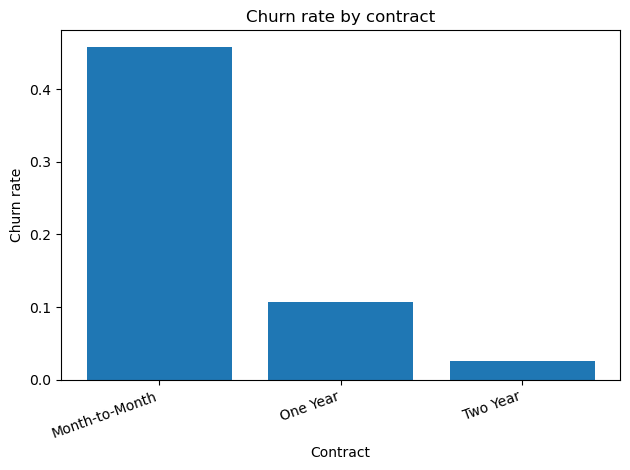

In [23]:
import matplotlib.pyplot as plt

df_contract = q(f"""
SELECT
  contract,
  1.0 * SUM(CASE WHEN churn_label='Yes' THEN 1 ELSE 0 END) / COUNT(*) AS churn_rate
FROM {TABLE_CLEAN}
GROUP BY contract
ORDER BY churn_rate DESC;
""")

plt.figure()
plt.bar(df_contract["contract"], df_contract["churn_rate"])
plt.title("Churn rate by contract")
plt.xlabel("Contract")
plt.ylabel("Churn rate")
plt.xticks(rotation=20, ha="right")
plt.tight_layout()
plt.show()


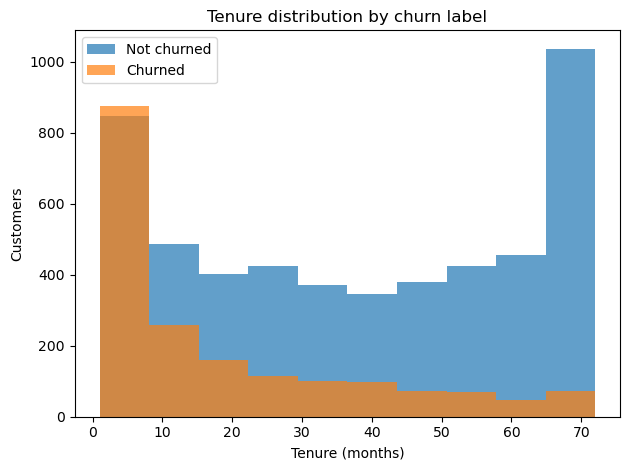

In [24]:
df_tenure = q(f"SELECT tenure_months, churn_label FROM {TABLE_CLEAN};")

plt.figure()
plt.hist(df_tenure.loc[df_tenure["churn_label"]=="No", "tenure_months"], alpha=0.7, label="Not churned")
plt.hist(df_tenure.loc[df_tenure["churn_label"]=="Yes", "tenure_months"], alpha=0.7, label="Churned")
plt.title("Tenure distribution by churn label")
plt.xlabel("Tenure (months)")
plt.ylabel("Customers")
plt.legend()
plt.tight_layout()
plt.show()


## 8) Conclusions
Use the headline metrics below to write a stakeholder-ready summary and recommendations.

Typical decision-oriented takeaways:
- Identify the highest churn segments (e.g., contract type, low tenure buckets).
- Quantify financial impact (avg revenue/CLTV differences).
- Prioritize churn drivers (top churn reasons).
- Propose targeted interventions aligned to reasons (pricing, service reliability, support quality).


In [25]:
overall = q(f"""
SELECT
  COUNT(*) AS customers,
  SUM(CASE WHEN churn_label='Yes' THEN 1 ELSE 0 END) AS churned_customers,
  ROUND(1.0 * SUM(CASE WHEN churn_label='Yes' THEN 1 ELSE 0 END) / COUNT(*), 4) AS churn_rate,
  ROUND(AVG(total_revenue), 2) AS avg_total_revenue,
  ROUND(AVG(satisfaction_score), 2) AS avg_satisfaction
FROM {TABLE_CLEAN};
""").iloc[0].to_dict()

top_contract = q(f"""
SELECT contract,
       ROUND(1.0 * SUM(CASE WHEN churn_label='Yes' THEN 1 ELSE 0 END) / COUNT(*), 4) AS churn_rate,
       COUNT(*) AS customers
FROM {TABLE_CLEAN}
GROUP BY contract
ORDER BY churn_rate DESC
LIMIT 1;
""").iloc[0].to_dict()

top_reason = q(f"""
SELECT churn_category, churn_reason, COUNT(*) AS churned_customers
FROM {TABLE_CLEAN}
WHERE churn_label='Yes'
GROUP BY churn_category, churn_reason
ORDER BY churned_customers DESC
LIMIT 1;
""").iloc[0].to_dict()

overall, top_contract, top_reason


({'customers': 7043.0,
  'churned_customers': 1869.0,
  'churn_rate': 0.2654,
  'avg_total_revenue': 3034.38,
  'avg_satisfaction': 3.24},
 {'contract': 'Month-to-Month', 'churn_rate': 0.4584, 'customers': 3610},
 {'churn_category': 'Competitor',
  'churn_reason': 'Competitor had better devices',
  'churned_customers': 313})

## 9) Notebook Formatting Notes
- Each SQL query is preceded by an English comment describing intent and expected insight.
- Sections mirror a standard analytics workflow.

## 10) Reusability Tips
- Switch to a file-backed SQLite DB for persistence (`sqlite3.connect("telco.db")`).
- Parameterize bucket thresholds in Python.
- Convert frequently used analyses into SQL views.
- Encapsulate repetitive SQL patterns (e.g., churn rate computation) into helper functions.
